# CZ gate in Rydberg atoms

In order to implement digital quantum computation in Rydberg atoms, ground state $|g\rangle$ and hyperfine state $|h\rangle$ are used as qubit states. Transitions between these two levels $|g\rangle \leftrightarrow |h\rangle$ can be induced with Raman pulses. However, in order to make entanglement between these two evels, another ancillary atomic level has to be introduced and it's called the Rydberg level $|r\rangle$. Transitions $|g\rangle \leftrightarrow |r\rangle$ are induced with so-called Rydberg pulses, and Rydberg interaction, which prohibits two neighboring atoms to both occupy Rydberg levels, can be used to generate entanglement between the atoms.

Here we set $|h\rangle \equiv |1\rangle$, $|g\rangle \equiv |2\rangle$, and $|r\rangle \equiv |3\rangle$. Hamiltonian of two Rydberg atoms can then be written as

$$H = \frac{\Omega(t)}{2}\left[e^{i\varphi(t)} \left(\sigma_+^{(1)} + \sigma_+^{(2)}\right) +  e^{-i\varphi(t)} \left(\sigma_-^{(1)} + \sigma_-^{(2)}\right)\right] - \Delta(t) (n_1 + n_2) + V n_1n_2,$$
where $\sigma^{(i)}_+ = |3\rangle\langle1|_i$, $\sigma^{(i)}_- = |1\rangle\langle3|_i$, and $n_i = |3\rangle\langle3|_i$.

In [1]:
using Sisyphus
using QuantumOptics
using Flux, DiffEqFlux
using Plots
using Random
using ProgressMeter

ProgressMeter.ijulia_behavior(:clear);

Since pulses are required to be real-valued, we have to rewrite the Hamiltonian

$$H = Vn_1n_2 - \Delta(t)(n_1 + n_2) + \frac{\Omega(t)\cos\varphi(t)}{2}\left(\sigma^{(1)}_x + \sigma^{(2)}_x\right) + \frac{\Omega(t)\sin\varphi(t)}{2}\left(\sigma^{(1)}_y + \sigma^{(2)}_y\right).$$

In [2]:
V = 2π*10.0 # MHz

bs = NLevelBasis(3)
bsys = bs⊗bs

id = identityoperator(bs)
sp1 = transition(bs, 3, 2)⊗id
sm1 = transition(bs, 2, 3)⊗id
sp2 = id⊗transition(bs, 3, 2)
sm2 = id⊗transition(bs, 2, 3)
n1 = transition(bs, 3, 3)⊗id
n2 = id⊗transition(bs, 3, 3)

H0 = V*n1*n2
H1 = (n1 + n2)
H2 = (sp1 + sp2 + sm1 + sm2)
H3 = 1.0im*(sp1 + sp2 - sm1 - sm2);

In [3]:
states= [nlevelstate(bs, 1)⊗nlevelstate(bs, 1),
         nlevelstate(bs, 1)⊗nlevelstate(bs, 2),
         nlevelstate(bs, 2)⊗nlevelstate(bs, 1),
         nlevelstate(bs, 2)⊗nlevelstate(bs, 2)]

trans = UnitaryTransform(states, [[1.0 0 0 0 ];[0 1.0 0 0 ];[0 0 1.0 0 ]; [0 0 0 -1.0]]);

In [4]:
heaviside(t) = 0.5 * (sign(t) + 1)
interval(t, a, b) = heaviside(t - a) - heaviside(t - b)

function piecewise(p, t; t0=0.0, t1=1.0)
    if length(p) == 0
        return 0.0
    end
    ts = collect(t0:t1/length(p):t1)
    sum(p[i] * interval(t, ts[i], ts[i + 1]) for i=1:length(ts) - 1)
end

t0, t1 = 0.0, 1.0 # in μs
Ω(p, t) = piecewise(p[begin:length(p)÷3], t; t0=t0, t1=t1)
Δ(p, t) = piecewise(p[length(p)÷3+1:2*length(p)÷3], t; t0=t0, t1=t1)
φ(p, t) = piecewise(p[2*length(p)÷3+1:end], t; t0=t0, t1=t1)

θ = vcat(2π * ones(8), 2π * ones(8), zeros(4), π * ones(4))
println("Number of parameters: ", length(θ))

Number of parameters: 24


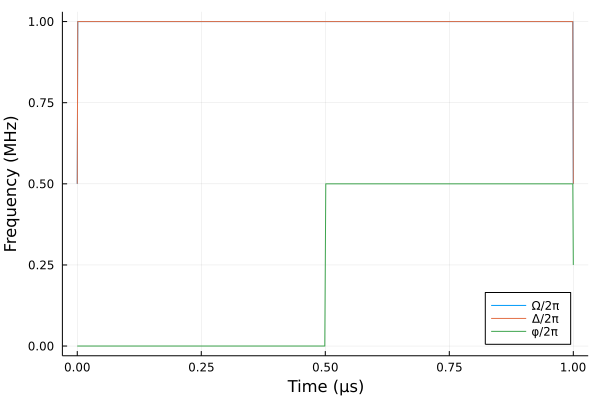

In [5]:
ts = collect(t0:t1/1000:t1)

plot(ts, [Ω(θ, t)/2π for t in ts], label="Ω/2π")
plot!(ts, [Δ(θ, t)/2π for t in ts], label="Δ/2π")
plot!(ts, [φ(θ, t)/2π for t in ts], label="φ/2π")
plot!(xlabel="Time (μs)", ylabel="Frequency (MHz)", legend=:bottomright)

We use `(x, y) -> 1.0 - real(x'*y)` as a cost function since it takes into account proper phases of final states.

In [6]:
coeffs(p, t) = [-Δ(p, t), Ω(p, t) * cos(φ(p, t)) / 2, Ω(p, t) * sin(φ(p, t)) / 2]
cost = CostFunction((x, y) -> 1.0 - real(x'*y))
H = Hamiltonian(H0, [H1, H2, H3], coeffs)

prob = QOCProblem(H, trans, (t0, t1), cost)
sol = solve(prob, θ, ADAM(0.1); maxiter=150, abstol=1e-6, reltol=1e-6);

Progress: 100%|█████████████████████████████████████████| Time: 0:05:35
  distance:     0.0002913917493617968
  constraints:  0.0


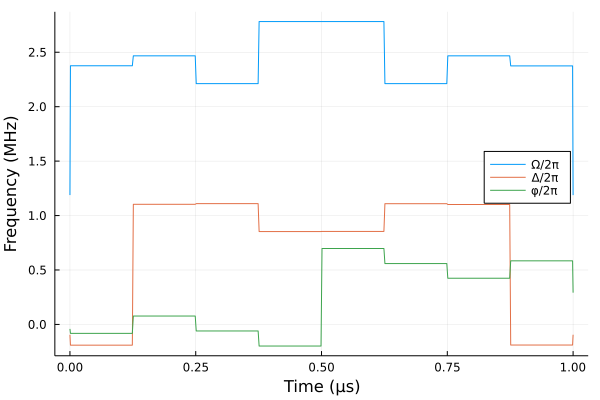

In [7]:
plot(ts, [Ω(sol.params, t)/2π for t in ts], label="Ω/2π")
plot!(ts, [Δ(sol.params, t)/2π for t in ts], label="Δ/2π")
plot!(ts, [φ(sol.params, t)/2π for t in ts], label="φ/2π")
plot!(xlabel="Time (μs)", ylabel="Frequency (MHz)", legend=:right)

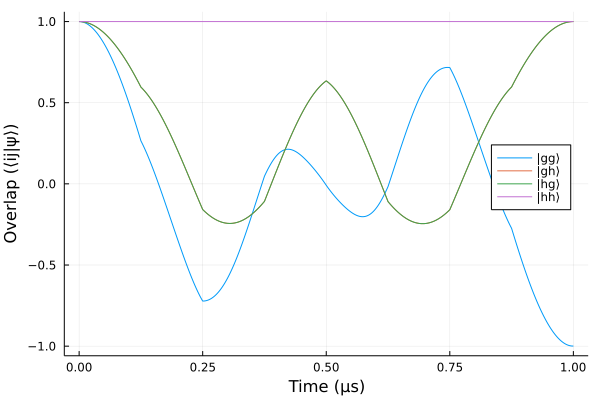

In [8]:
tout, psit22 = schroedinger_dynamic(ts, nlevelstate(bs, 2)⊗nlevelstate(bs, 2), H, sol.params)
tout, psit21 = schroedinger_dynamic(ts, nlevelstate(bs, 2)⊗nlevelstate(bs, 1), H, sol.params)
tout, psit12 = schroedinger_dynamic(ts, nlevelstate(bs, 1)⊗nlevelstate(bs, 2), H, sol.params)
tout, psit11 = schroedinger_dynamic(ts, nlevelstate(bs, 1)⊗nlevelstate(bs, 1), H, sol.params)

plot(tout, [real((nlevelstate(bs, 2)⊗nlevelstate(bs, 2))'*elm) for elm in psit22], label="|gg⟩")
plot!(tout, [real((nlevelstate(bs, 2)⊗nlevelstate(bs, 1))'*elm) for elm in psit21], label="|gh⟩")
plot!(tout, [real((nlevelstate(bs, 1)⊗nlevelstate(bs, 2))'*elm) for elm in psit12], label="|hg⟩")
plot!(tout, [real((nlevelstate(bs, 1)⊗nlevelstate(bs, 1))'*elm) for elm in psit11], label="|hh⟩")
plot!(xlabel="Time (µs)", ylabel="Overlap (⟨ij|ψ⟩)", legend=:right)